In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
from prophet import Prophet

In [321]:
df = pd.read_csv('donnees_meteo_148_stations.csv')

#### Supression des station de ski fermées du dataset

In [322]:
stations_fermees = [
    "Alex", "Bozel", "Brison", "Burzier", "Cellier Valmorel", "Chamonix - les Pèlerins",
    "Col de Creusaz", "Col des Aravis", "Col du Champet", "Col du Chaussy", "Col du Frêne",
    "Col du Galibier", "Col du Plainpalais", "Col du Pré", "Col du Sommeiller", "Col du Tamié",
    "Crey Rond", "Doucy en Bauges", "Drouzin-Le-Mont", "Entremont", "Granier sur Aime",
    "Jarrier - La Tuvière", "La Sambuy", "Le Bouchet - Mont Charvin", "Le Cry - Salvagny",
    "Le Petit Bornand", "Les Bossons - Chamonix", "Marthod", "Molliessoulaz", "Montisel",
    "Notre Dame du pré", "Richebourg", "Saint Nicolas la Chapelle", "Saint-Jean de Sixt",
    "Sainte Foy", "Saxel", "Serraval", "Seytroux", "Sixt Fer à Cheval", "St-Pierre d'Entremont",
    "Termignon", "Thônes", "Thorens Glières", "Ugine", "Val Pelouse",
    "Verthemex - Mont du Chat", "Villards sur Thônes"
]

In [323]:
for station in stations_fermees:
    suppression = df[df["stations"].apply(lambda x: station in x)].index
    df = df.drop(suppression)

#### Suppression des colonnes inutiles du dataset

In [324]:
df = df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y", "latitude", "longitude", "snowfall_water_equivalent_sum","snowfall_sum", "wind_speed_10m_mean", "soil_temperature_0_to_100cm_mean", "temperature_2m_max", "sunshine_duration", "cloud_cover_mean","rain_sum",
       "temperature_2m_min"], axis=1)

#### 

# PROPHET

In [325]:
# Conversion du type date
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

# Renom les colonnes pour Prophet
df = df.rename(columns={
    'date': 'ds',
    'temperature_2m_mean': 'y'
})

## PROPHET par an

In [326]:
# Agrégation annuelle
df_annee = df.copy()
df_annee['ds'] = pd.to_datetime(df_annee['ds'])


# Supression des données après le 31/08/2024
df_annee = df_annee[df_annee["ds"] < "2025-01-01"]


df_annee = (
    df_annee
    .set_index('ds')
    .resample('YS')  # début de chaque année (ex: 2020-01-01)
    .agg({
        'y': 'mean',  # cumul de neige annuel    
        'altitude': 'first'
    })
    .reset_index()
)

In [327]:
# Initialisation du modèle
model = Prophet(
    yearly_seasonality=False,  # utile car on a de la saisonnalité annuelle
    daily_seasonality=False,  # on n'a pas besoin de saisonnalité journalière ici
    weekly_seasonality=False,  # éventuellement activable si besoin
    changepoint_prior_scale=1,       # par défaut : 0.05
    seasonality_prior_scale=10          # par défaut : 10
)

In [328]:
# On s'assure de ne garder que les colonnes utiles et sans NaN
df_train = df_annee[['ds', 'y']]

# Entraînement
model.fit(df_train)

# Prévision
future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing


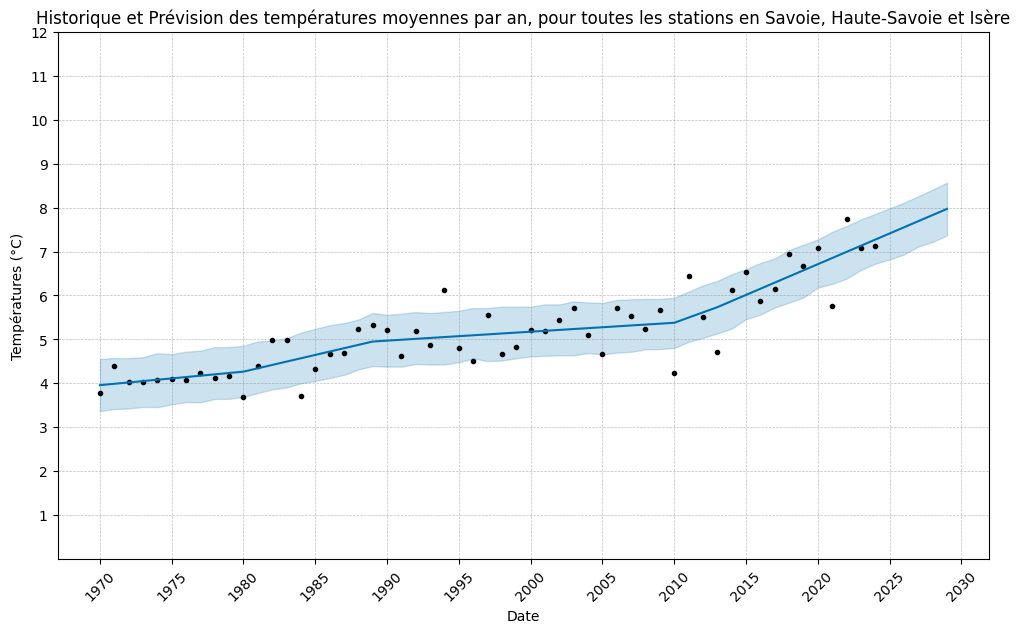

In [329]:
fig = model.plot(forecast)
plt.ylim(0, 12)
plt.yticks(range(1, 13))
plt.title("Historique et Prévision des températures moyennes par an, pour toutes les stations en Savoie, Haute-Savoie et Isère")
plt.xlabel("Date")
plt.ylabel("Températures (°C)")
locator = mdates.YearLocator(5)
formatter = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## PROPHET par an par altitude

In [330]:
df_1000 = df[df["altitude"] < 1000.0]
df_1000_1300 = df[(df["altitude"] < 1300.0) & (df["altitude"] >= 1000.0)]
df_1300_1600 = df[(df["altitude"] < 1600.0) & (df["altitude"] >= 1300.0)]
df_1600 = df[df["altitude"] >= 1600.0]

#### En dessous de 1000 m d'altitude

In [331]:
# Agrégation annuelle
df_annee_1000 = df_1000.copy()
df_annee_1000['ds'] = pd.to_datetime(df_annee_1000['ds'])


# Supression des données après le 31/08/2024
df_annee_1000 = df_annee_1000[df_annee_1000["ds"] < "2025-01-01"]


df_annee_1000 = (
    df_annee_1000
    .set_index('ds')
    .resample('YS')  # début de chaque année (ex: 2020-01-01)
    .agg({
        'y': 'mean',  # cumul des températures moyennes annuel
        'altitude': 'first'
    })
    .reset_index()
)

In [332]:
# Initialisation du modèle
model = Prophet(
    yearly_seasonality=False,  # utile car on a de la saisonnalité annuelle
    daily_seasonality=False,  # on n'a pas besoin de saisonnalité journalière ici
    weekly_seasonality=False,  # éventuellement activable si besoin
    changepoint_prior_scale=1,       # par défaut : 0.05
    seasonality_prior_scale=10          # par défaut : 10
)

In [333]:
# On s'assure de ne garder que les colonnes utiles et sans NaN
df_train = df_annee_1000[['ds', 'y']]

# Entraînement
model.fit(df_train)

# Prévision
future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing


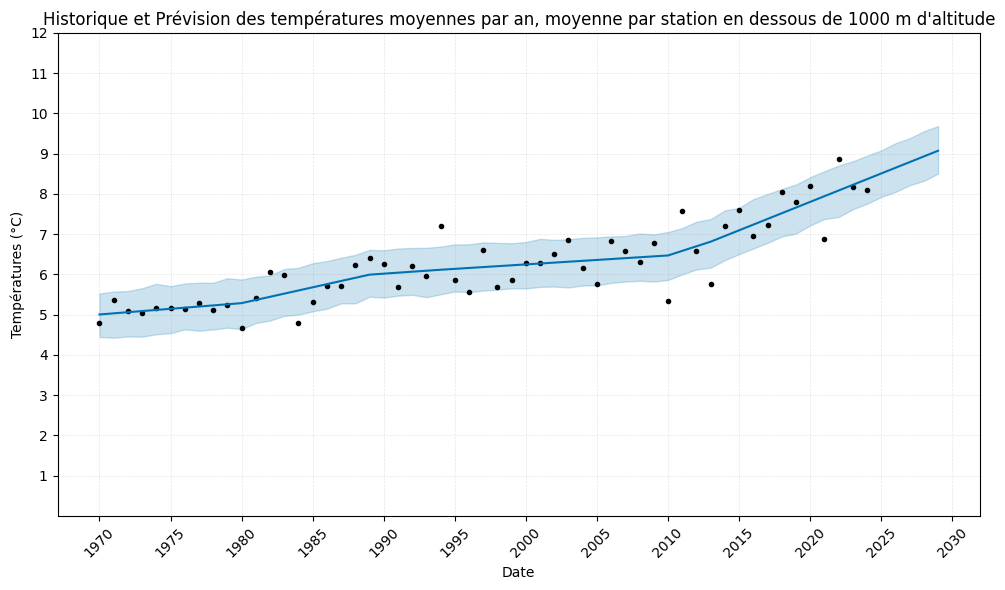

In [342]:
fig = model.plot(forecast)

plt.ylim(0, 12)
plt.yticks(range(1, 13))

plt.title("Historique et Prévision des températures moyennes par an, moyenne par station en dessous de 1000 m d'altitude")
plt.xlabel("Date")
plt.ylabel("Températures (°C)")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

locator = mdates.YearLocator(5)
formatter = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Entre 1000 et 1300 m d'altitude

In [335]:
# Agrégation annuelle
df_annee_1000_1300 = df_1000_1300.copy()
df_annee_1000_1300['ds'] = pd.to_datetime(df_annee_1000_1300['ds'])


# Supression des données après le 31/08/2024
df_annee_1000_1300 = df_annee_1000_1300[df_annee_1000_1300["ds"] < "2025-01-01"]


df_annee_1000_1300 = (
    df_annee_1000_1300
    .set_index('ds')
    .resample('YS')  # début de chaque année (ex: 2020-01-01)
    .agg({
        'y': 'mean',  # cumul des températures annuelles
        'altitude': 'first'
    })
    .reset_index()
)

In [336]:
# Initialisation du modèle
model = Prophet(
    yearly_seasonality=False,  # utile car on a de la saisonnalité annuelle
    daily_seasonality=False,  # on n'a pas besoin de saisonnalité journalière ici
    weekly_seasonality=False,  # éventuellement activable si besoin
    changepoint_prior_scale=1,       # par défaut : 0.05
    seasonality_prior_scale=10          # par défaut : 10
)

In [337]:
# On s'assure de ne garder que les colonnes utiles et sans NaN
df_train = df_annee_1000_1300[['ds', 'y']]

# Entraînement
model.fit(df_train)

# Prévision
future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:27 - cmdstanpy - INFO - Chain [1] done processing


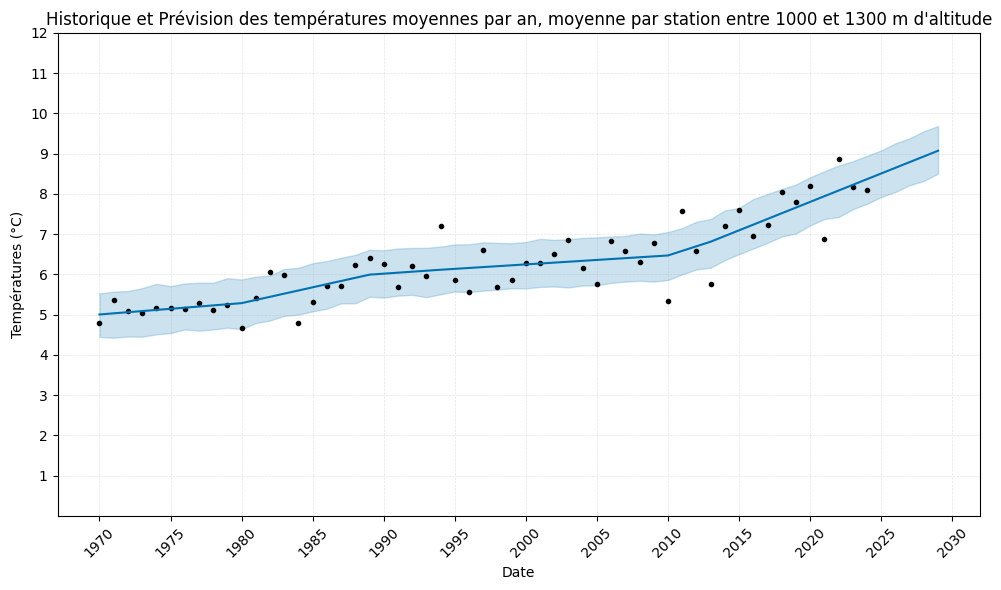

In [343]:
fig = model.plot(forecast)

plt.ylim(0, 12)
plt.yticks(range(1, 13))

plt.title("Historique et Prévision des températures moyennes par an, moyenne par station entre 1000 et 1300 m d'altitude")
plt.xlabel("Date")
plt.ylabel("Températures (°C)")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

locator = mdates.YearLocator(5)
formatter = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Entre 1300 et 1600 m d'altitude

In [344]:
# Agrégation annuelle
df_annee_1300_1600 = df_1300_1600.copy()
df_annee_1300_1600['ds'] = pd.to_datetime(df_annee_1300_1600['ds'])


# Supression des données après le 31/08/2024
df_annee_1300_1600 = df_annee_1300_1600[df_annee_1300_1600["ds"] < "2025-01-01"]


df_annee_1300_1600 = (
    df_annee_1300_1600
    .set_index('ds')
    .resample('YS')  # début de chaque année (ex: 2020-01-01)
    .agg({
        'y': 'mean',  # cumul des moyennes de tempéraures annuel
        'altitude': 'first'
    })
    .reset_index()
)

In [345]:
# Initialisation du modèle
model = Prophet(
    yearly_seasonality=False,  # utile car on a de la saisonnalité annuelle
    daily_seasonality=False,  # on n'a pas besoin de saisonnalité journalière ici
    weekly_seasonality=False,  # éventuellement activable si besoin
    changepoint_prior_scale=1,       # par défaut : 0.05
    seasonality_prior_scale=10          # par défaut : 10
)

In [346]:
# On s'assure de ne garder que les colonnes utiles et sans NaN
df_train = df_annee_1300_1600[['ds', 'y']]

# Entraînement
model.fit(df_train)

# Prévision
future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

13:27:15 - cmdstanpy - INFO - Chain [1] start processing
13:27:16 - cmdstanpy - INFO - Chain [1] done processing


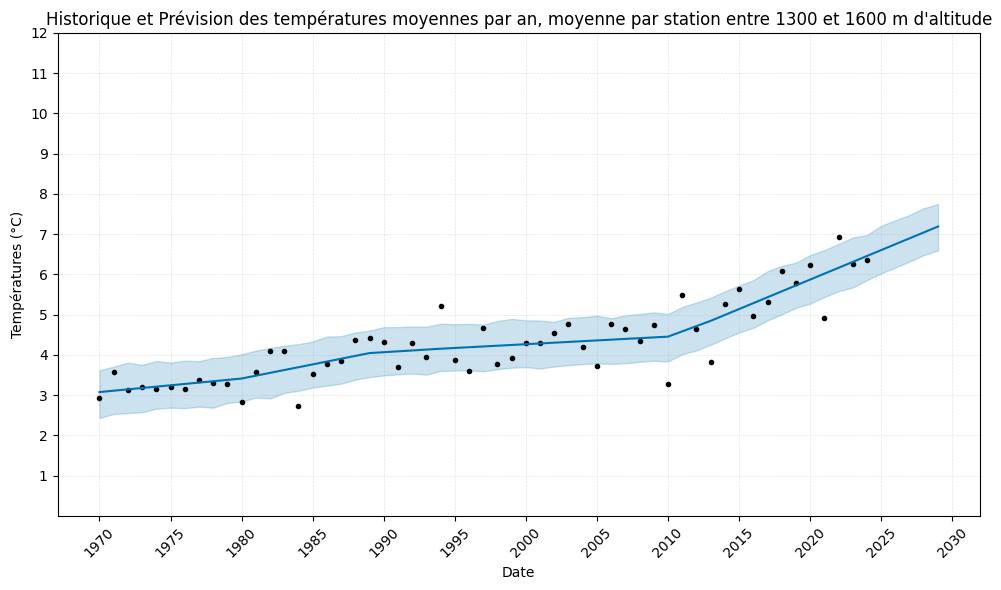

In [348]:
fig = model.plot(forecast)

plt.ylim(0, 12)
plt.yticks(range(1, 13))

plt.title("Historique et Prévision des températures moyennes par an, moyenne par station entre 1300 et 1600 m d'altitude")
plt.xlabel("Date")
plt.ylabel("Températures (°C)")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

locator = mdates.YearLocator(5)
formatter = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Au dessus de 1600 m d'altitude

In [349]:
# Agrégation annuelle
df_annee_1600 = df_1600.copy()
df_annee_1600['ds'] = pd.to_datetime(df_annee_1600['ds'])


# Supression des données après le 31/08/2024
df_annee_1600 = df_annee_1600[df_annee_1600["ds"] < "2025-01-01"]


df_annee_1600 = (
    df_annee_1600
    .set_index('ds')
    .resample('YS')  # début de chaque année (ex: 2020-01-01)
    .agg({
        'y': 'mean',  # cumul des moyennes de températures annuel
        'altitude': 'first'
    })
    .reset_index()
)

In [350]:
# Initialisation du modèle
model = Prophet(
    yearly_seasonality=False,  # utile car on a de la saisonnalité annuelle
    daily_seasonality=False,  # on n'a pas besoin de saisonnalité journalière ici
    weekly_seasonality=False,  # éventuellement activable si besoin
    changepoint_prior_scale=1,       # par défaut : 0.05
    seasonality_prior_scale=10          # par défaut : 10
)

In [351]:
# On s'assure de ne garder que les colonnes utiles et sans NaN
df_train = df_annee_1600[['ds', 'y']]

# Entraînement
model.fit(df_train)

# Prévision
future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

13:27:36 - cmdstanpy - INFO - Chain [1] start processing
13:27:36 - cmdstanpy - INFO - Chain [1] done processing


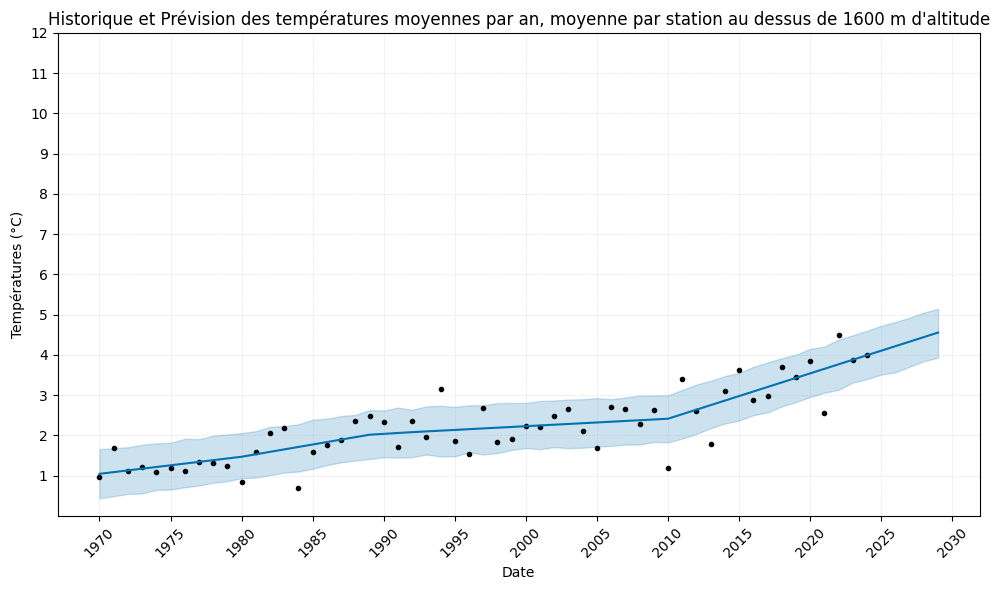

In [353]:
fig = model.plot(forecast)

plt.ylim(0, 12)
plt.yticks(range(1, 13))

plt.title("Historique et Prévision des températures moyennes par an, moyenne par station au dessus de 1600 m d'altitude")
plt.xlabel("Date")
plt.ylabel("Températures (°C)")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

locator = mdates.YearLocator(5)
formatter = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## PROPHET par station

In [354]:
df["stations"].unique()

array(['Les Arcs', 'Les Brasses', 'Tignes', 'Valmorel', 'Doucy',
       'Les Saisies', 'Savoie Grand Revard', 'Les Bottières',
       'Saint Colomban des Villards', 'Val Cenis', 'La Toussuire',
       'Sollières - Sardières', 'Le Corbier', 'Les Karellis', 'Aussois',
       "Saint Sorlin d'Arves", 'Passy Plaine Joux', 'Praz de Lys Sommand',
       "Roc d'Enfer - St Jean d'Aulps", 'Saint Gervais Mont-Blanc',
       'Aillons Margeriaz', 'Areches Beaufort', 'Crest Voland Cohennoz',
       'Flumet - St Nicolas la Chapelle', 'La Rosière 1850',
       'Montchavin - La Plagne', 'Peisey-Vallandry', 'Les Habères',
       'Montmin - Col de la Forclaz', 'Méribel', 'Courchevel',
       'Pralognan la Vanoise', 'Saint Martin de Belleville',
       'Bonneval sur Arc', 'Les Menuires', 'Bessans', 'Val Thorens',
       'Bramans', 'Champagny en Vanoise', 'Brides les Bains',
       "Val d'Isère", 'La Plagne', 'La Tania', 'Morillon', 'Samoëns',
       'Mont Saxonnex', 'Romme', 'Les Carroz', "La Chapelle d'A

In [355]:
station_choisie = input("Entrez le nom de la station pour laquelle vous souhaitez afficher des prédictions : ")

In [356]:
df_station = df[df['stations'] == station_choisie]

In [357]:
df_station_agg = (
    df_station
    .set_index('ds')
    .resample('YS')
    .agg({
        'y': 'mean',  # cumul de neige par an
        'altitude': 'first'
    })
    .reset_index()
)

In [358]:
# Paramètres du modèle
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=1,       # par défaut : 0.05
    seasonality_prior_scale=10          # par défaut : 10
)

# Entraînement
model.fit(df_station_agg)

13:28:04 - cmdstanpy - INFO - Chain [1] start processing
13:28:05 - cmdstanpy - INFO - Chain [1] done processing


In [359]:
future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

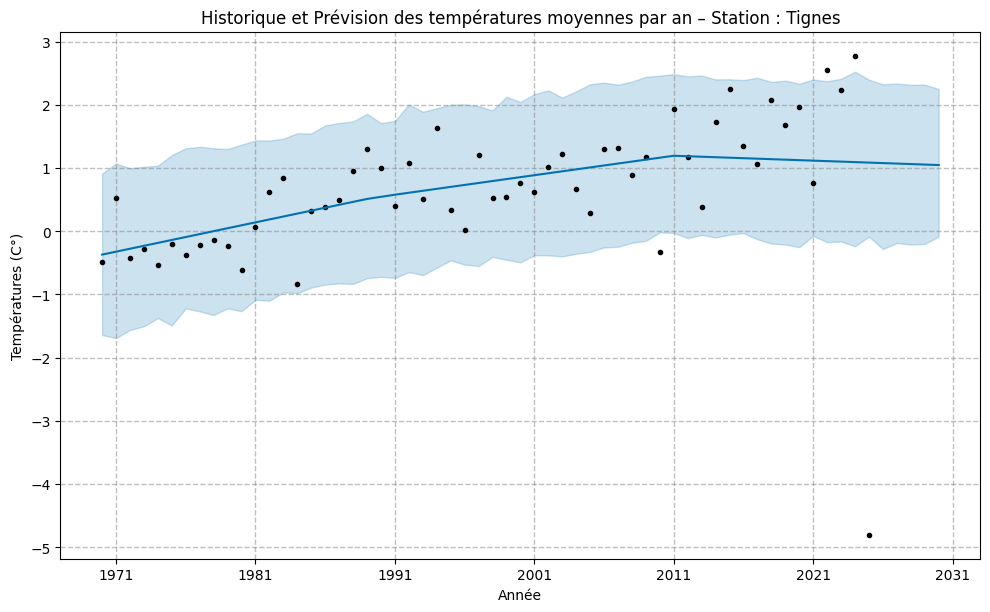

In [360]:
fig = model.plot(forecast)
plt.title(f"Historique et Prévision des températures moyennes par an – Station : {station_choisie}")
plt.xlabel("Année")
plt.ylabel("Températures (C°)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()